In [1]:
from scipy.io import arff
import pandas as pd
import os
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from colorama import Fore
import seaborn as sns
import impyute as impy
from sklearn.model_selection import train_test_split

# ucitavanje podataka 
def load_data_sets():
    ds = []
    data_path = '..'
    data_path = os.path.join(data_path, 'data')
    files = sorted(os.listdir(data_path))
    
    atr_names = [f'X{i}' for i in range(1, 65)]
    atr_names.append('class')

    for file in files:
        full_file_path = os.path.join(data_path, file)
        data = arff.loadarff(full_file_path)
        df = pd.DataFrame(data[0])
        df.columns = atr_names
        ds.append(df)
    return ds
        
        
data_sets = load_data_sets()
data_sets[0].head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


# <span style="color:#7140ff">Attribute Information</span>

**X1**	net profit / total assets

**X2**	total liabilities / total assets

**X3**	working capital / total assets

**X4**	current assets / short-term liabilities

**X5**	((cash + short-term securities + receivables - short-term liabilities)/(operating expenses - depreciation))*365

**X6**	retained earnings / total assets

**X7**	EBIT / total assets

**X8**	book value of equity / total liabilities

**X9**	sales / total assets

**X10**	equity / total assets

**X11**	(gross profit + extraordinary items + financial expenses) / total assets

**X12**	gross profit / short-term liabilities

**X13**	(gross profit + depreciation) / sales

**X14**	(gross profit + interest) / total assets

**X15**	(total liabilities * 365) / (gross profit + depreciation)

**X16**	(gross profit + depreciation) / total liabilities

**X17**	total assets / total liabilities

**X18**	gross profit / total assets

**X19**	gross profit / sales

**X20**	(inventory * 365) / sales

**X21**	sales (n) / sales (n-1)

**X22**	profit on operating activities / total assets

**X23**	net profit / sales

**X24**	gross profit (in 3 years) / total assets

**X25**	(equity - share capital) / total assets

**X26**	(net profit + depreciation) / total liabilities

**X27**	profit on operating activities / financial expenses

**X28**	working capital / fixed assets

**X29**	logarithm of total assets

**X30**	(total liabilities - cash) / sales

**X31**	(gross profit + interest) / sales

**X32**	(current liabilities * 365) / cost of products sold

**X33**	operating expenses / short-term liabilities

**X34**	operating expenses / total liabilities

**X35**	profit on sales / total assets

**X36**	total sales / total assets

**X37**	(current assets - inventories) / long-term liabilities

**X38**	constant capital / total assets

**X39**	profit on sales / sales

**X40**	(current assets - inventory - receivables) / short-term liabilities

**X41**	total liabilities / ((profit on operating activities + depreciation) * (12/365))

**X42**	profit on operating activities / sales

**X43**	rotation receivables + inventory turnover in days

**X44**	(receivables * 365) / sales

**X45** net profit / inventory

**X46**	(current assets - inventory) / short-term liabilities

**X47**	(inventory * 365) / cost of products sold

**X48**	EBITDA (profit on operating activities - depreciation) / total assets

**X49**	EBITDA (profit on operating activities - depreciation) / sales

**X50**	current assets / total liabilities

**X51**	short-term liabilities / total assets

**X52**	(short-term liabilities * 365) / cost of products sold)

**X53**	equity / fixed assets

**X54**	constant capital / fixed assets

**X55**	working capital

**X56**	(sales - cost of products sold) / sales

**X57**	(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)

**X58**	total costs /total sales

**X59**	long-term liabilities / equity

**X60**	sales / inventory

**X61**	sales / receivables

**X62**	(short-term liabilities *365) / sales

**X63**	sales / short-term liabilities

**X64**	sales / fixed assets

In [2]:
# prebacivanje klasa u tip int
for i in range(len(data_sets)):
    column = getattr(data_sets[i], 'class')
    data_sets[i]['class'] = column.astype(np.int32)

# Rad sa nedostajucim vrednostima

In [3]:
missing_data = []

for data_set in data_sets:
    len1 = len(data_set)
    len2 = len(data_set.dropna())
    ratio = 1-len2 / len1
    missing_data.append([len1, len2, ratio])
    
missing_data = pd.DataFrame(np.array(missing_data), columns=['total', 'missing value', 'data loss'],
                        index=[f'{i} year' for i in range(1, 6)])
missing_data

,total,missing value,data loss
1 year,7027.0,3194.0,0.545467
2 year,10173.0,4088.0,0.598152
3 year,10503.0,4885.0,0.534895
4 year,9792.0,4769.0,0.512970
5 year,5910.0,3031.0,0.487140


Izbacivanjem gubimo oko 50% podataka, a samim time i znacajan deo informacija.

## Vizualizacija nedostajucih vrednosti po atributima

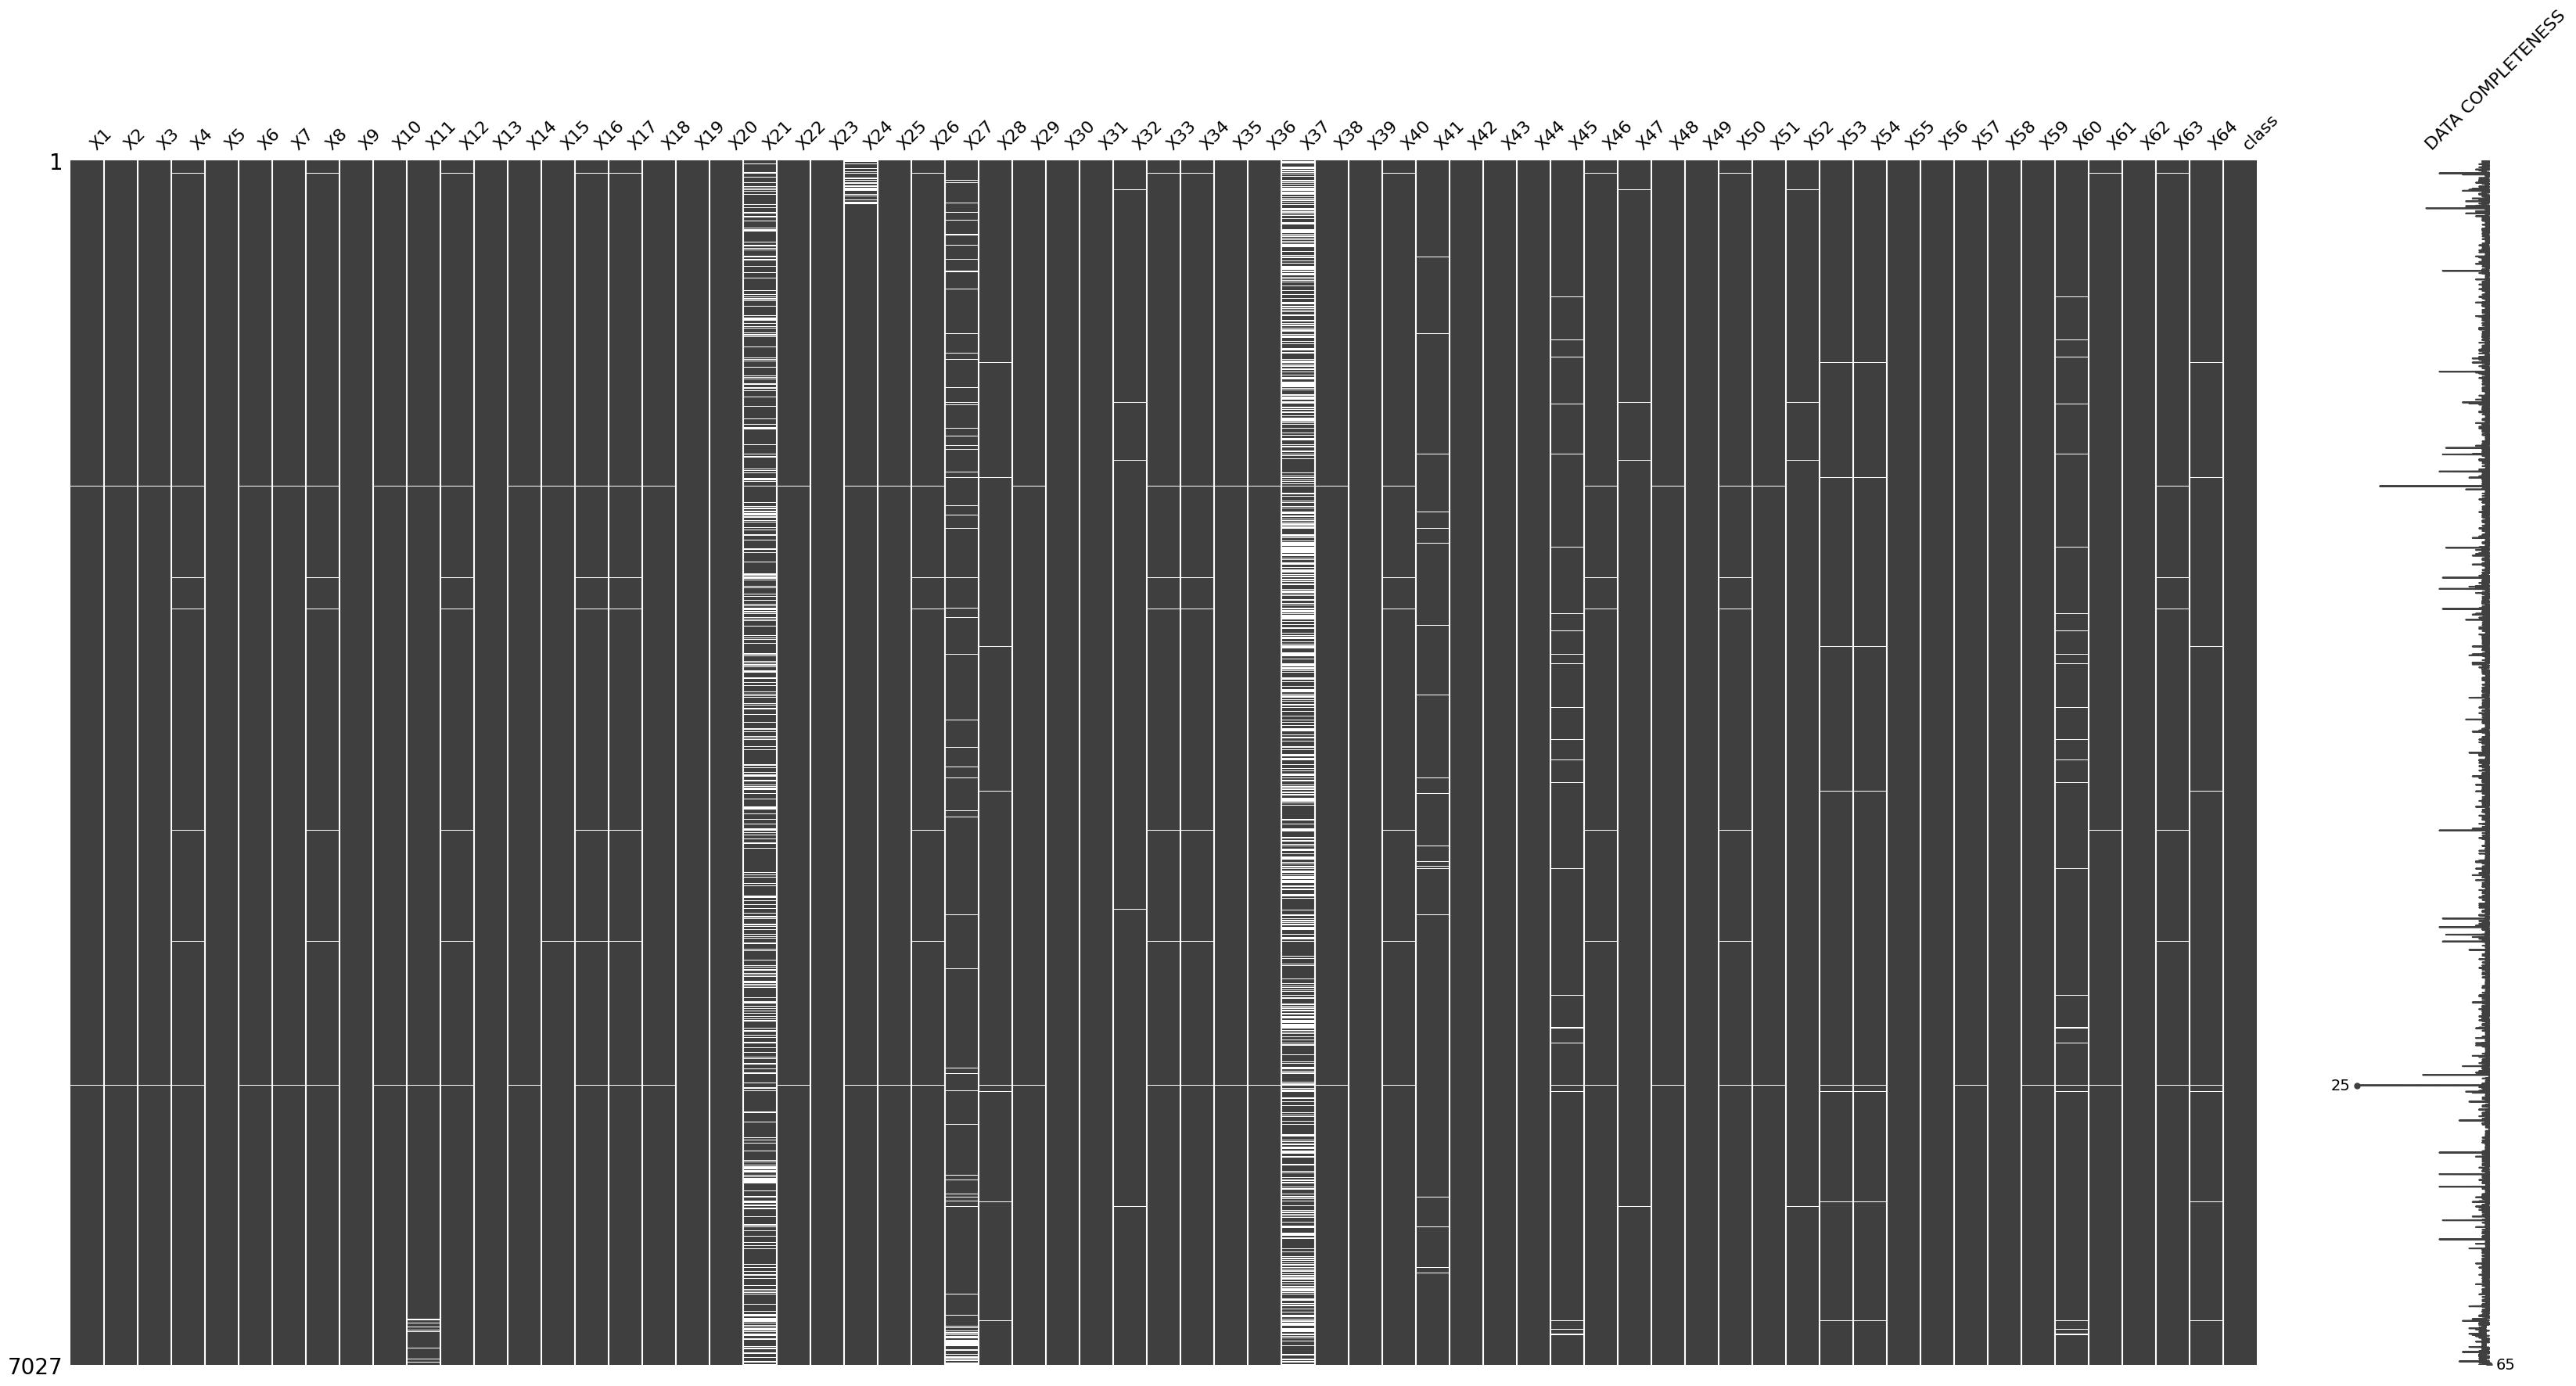

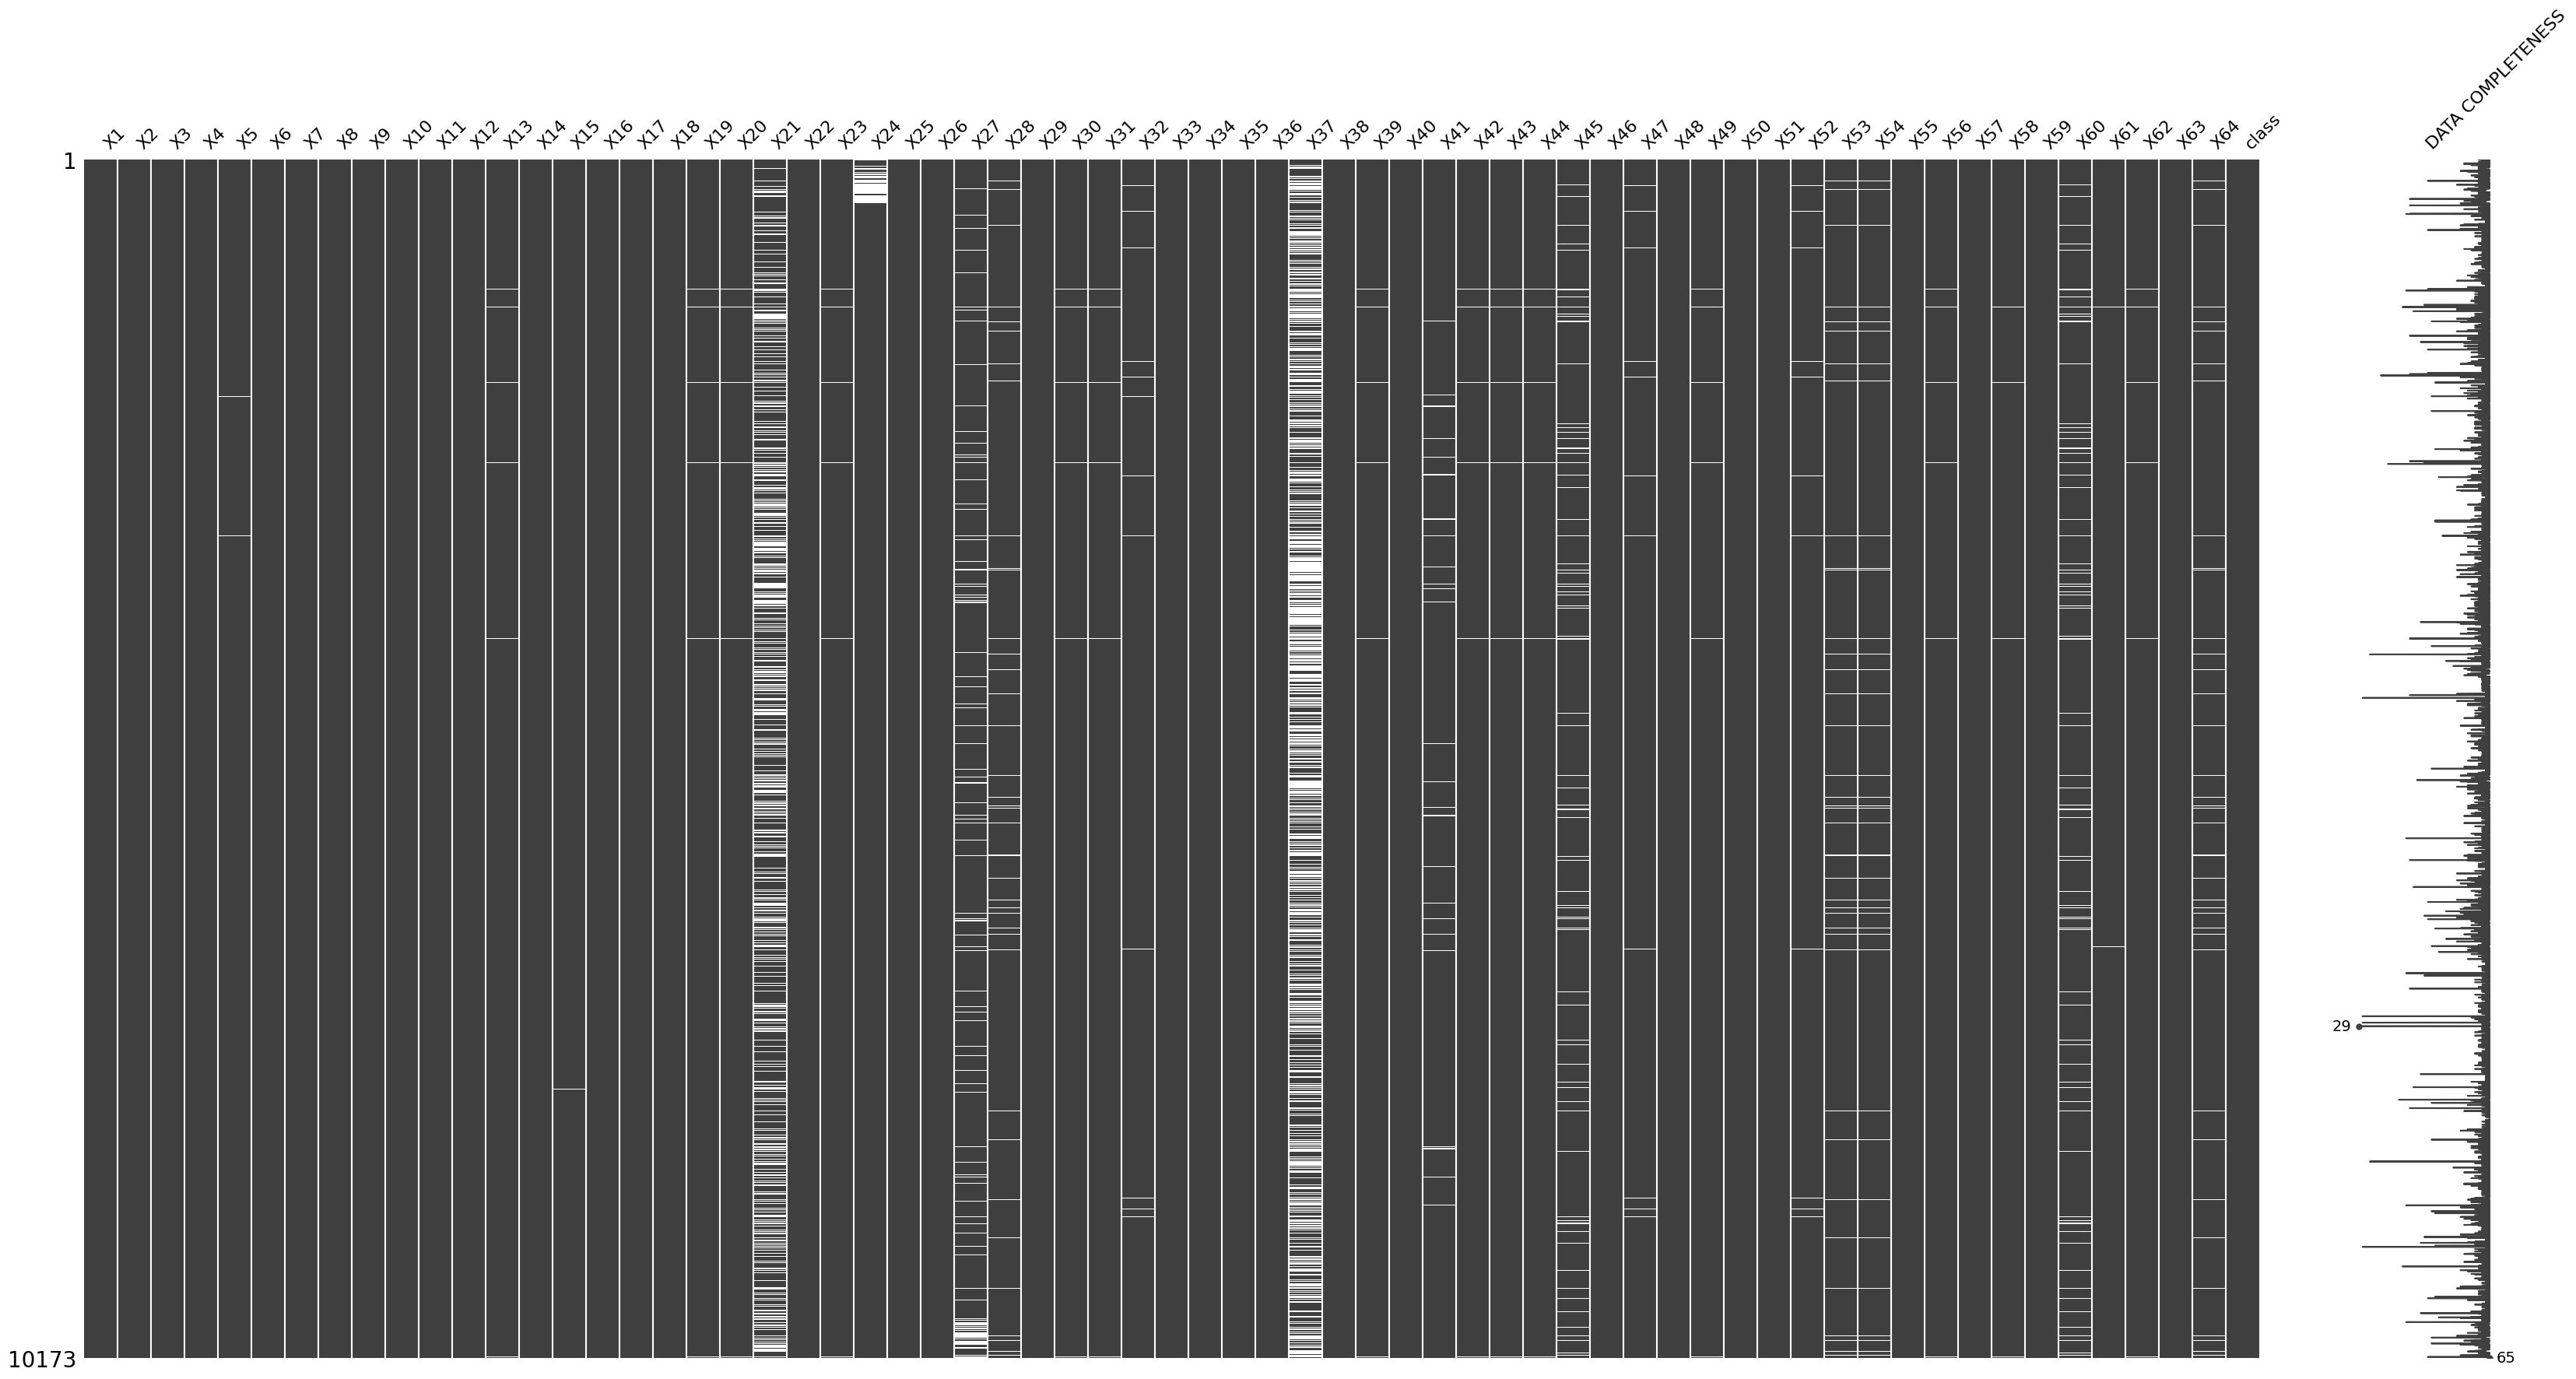

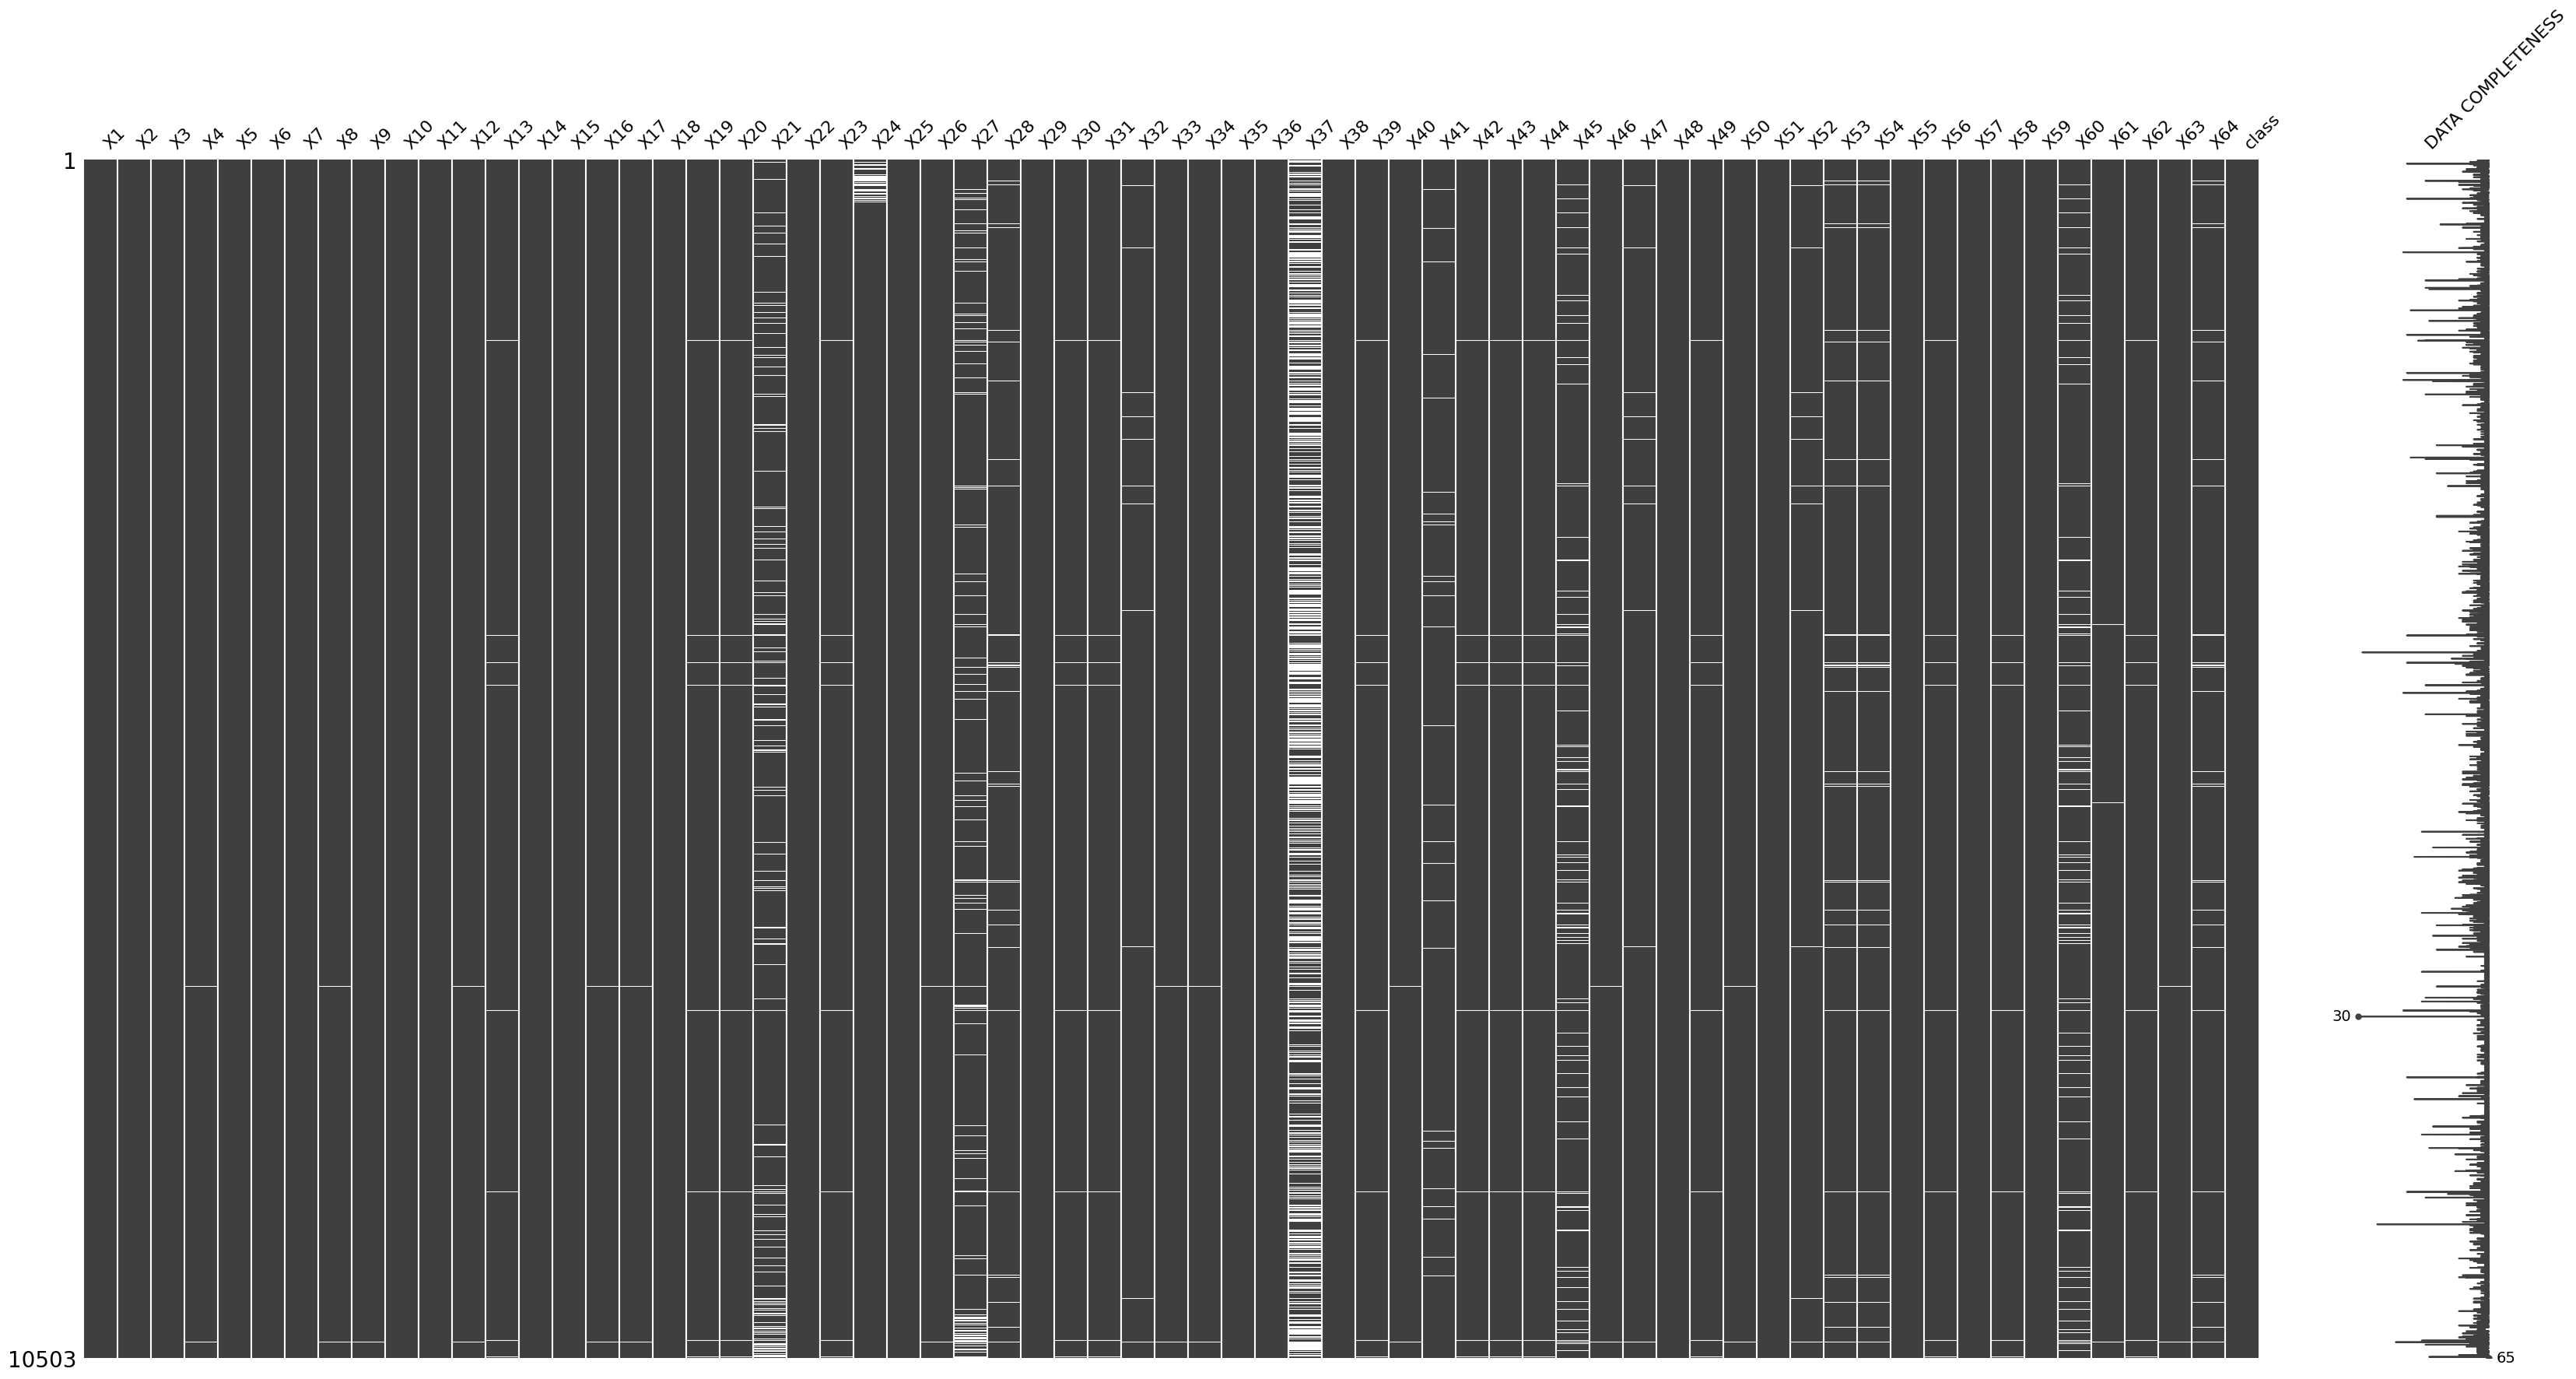

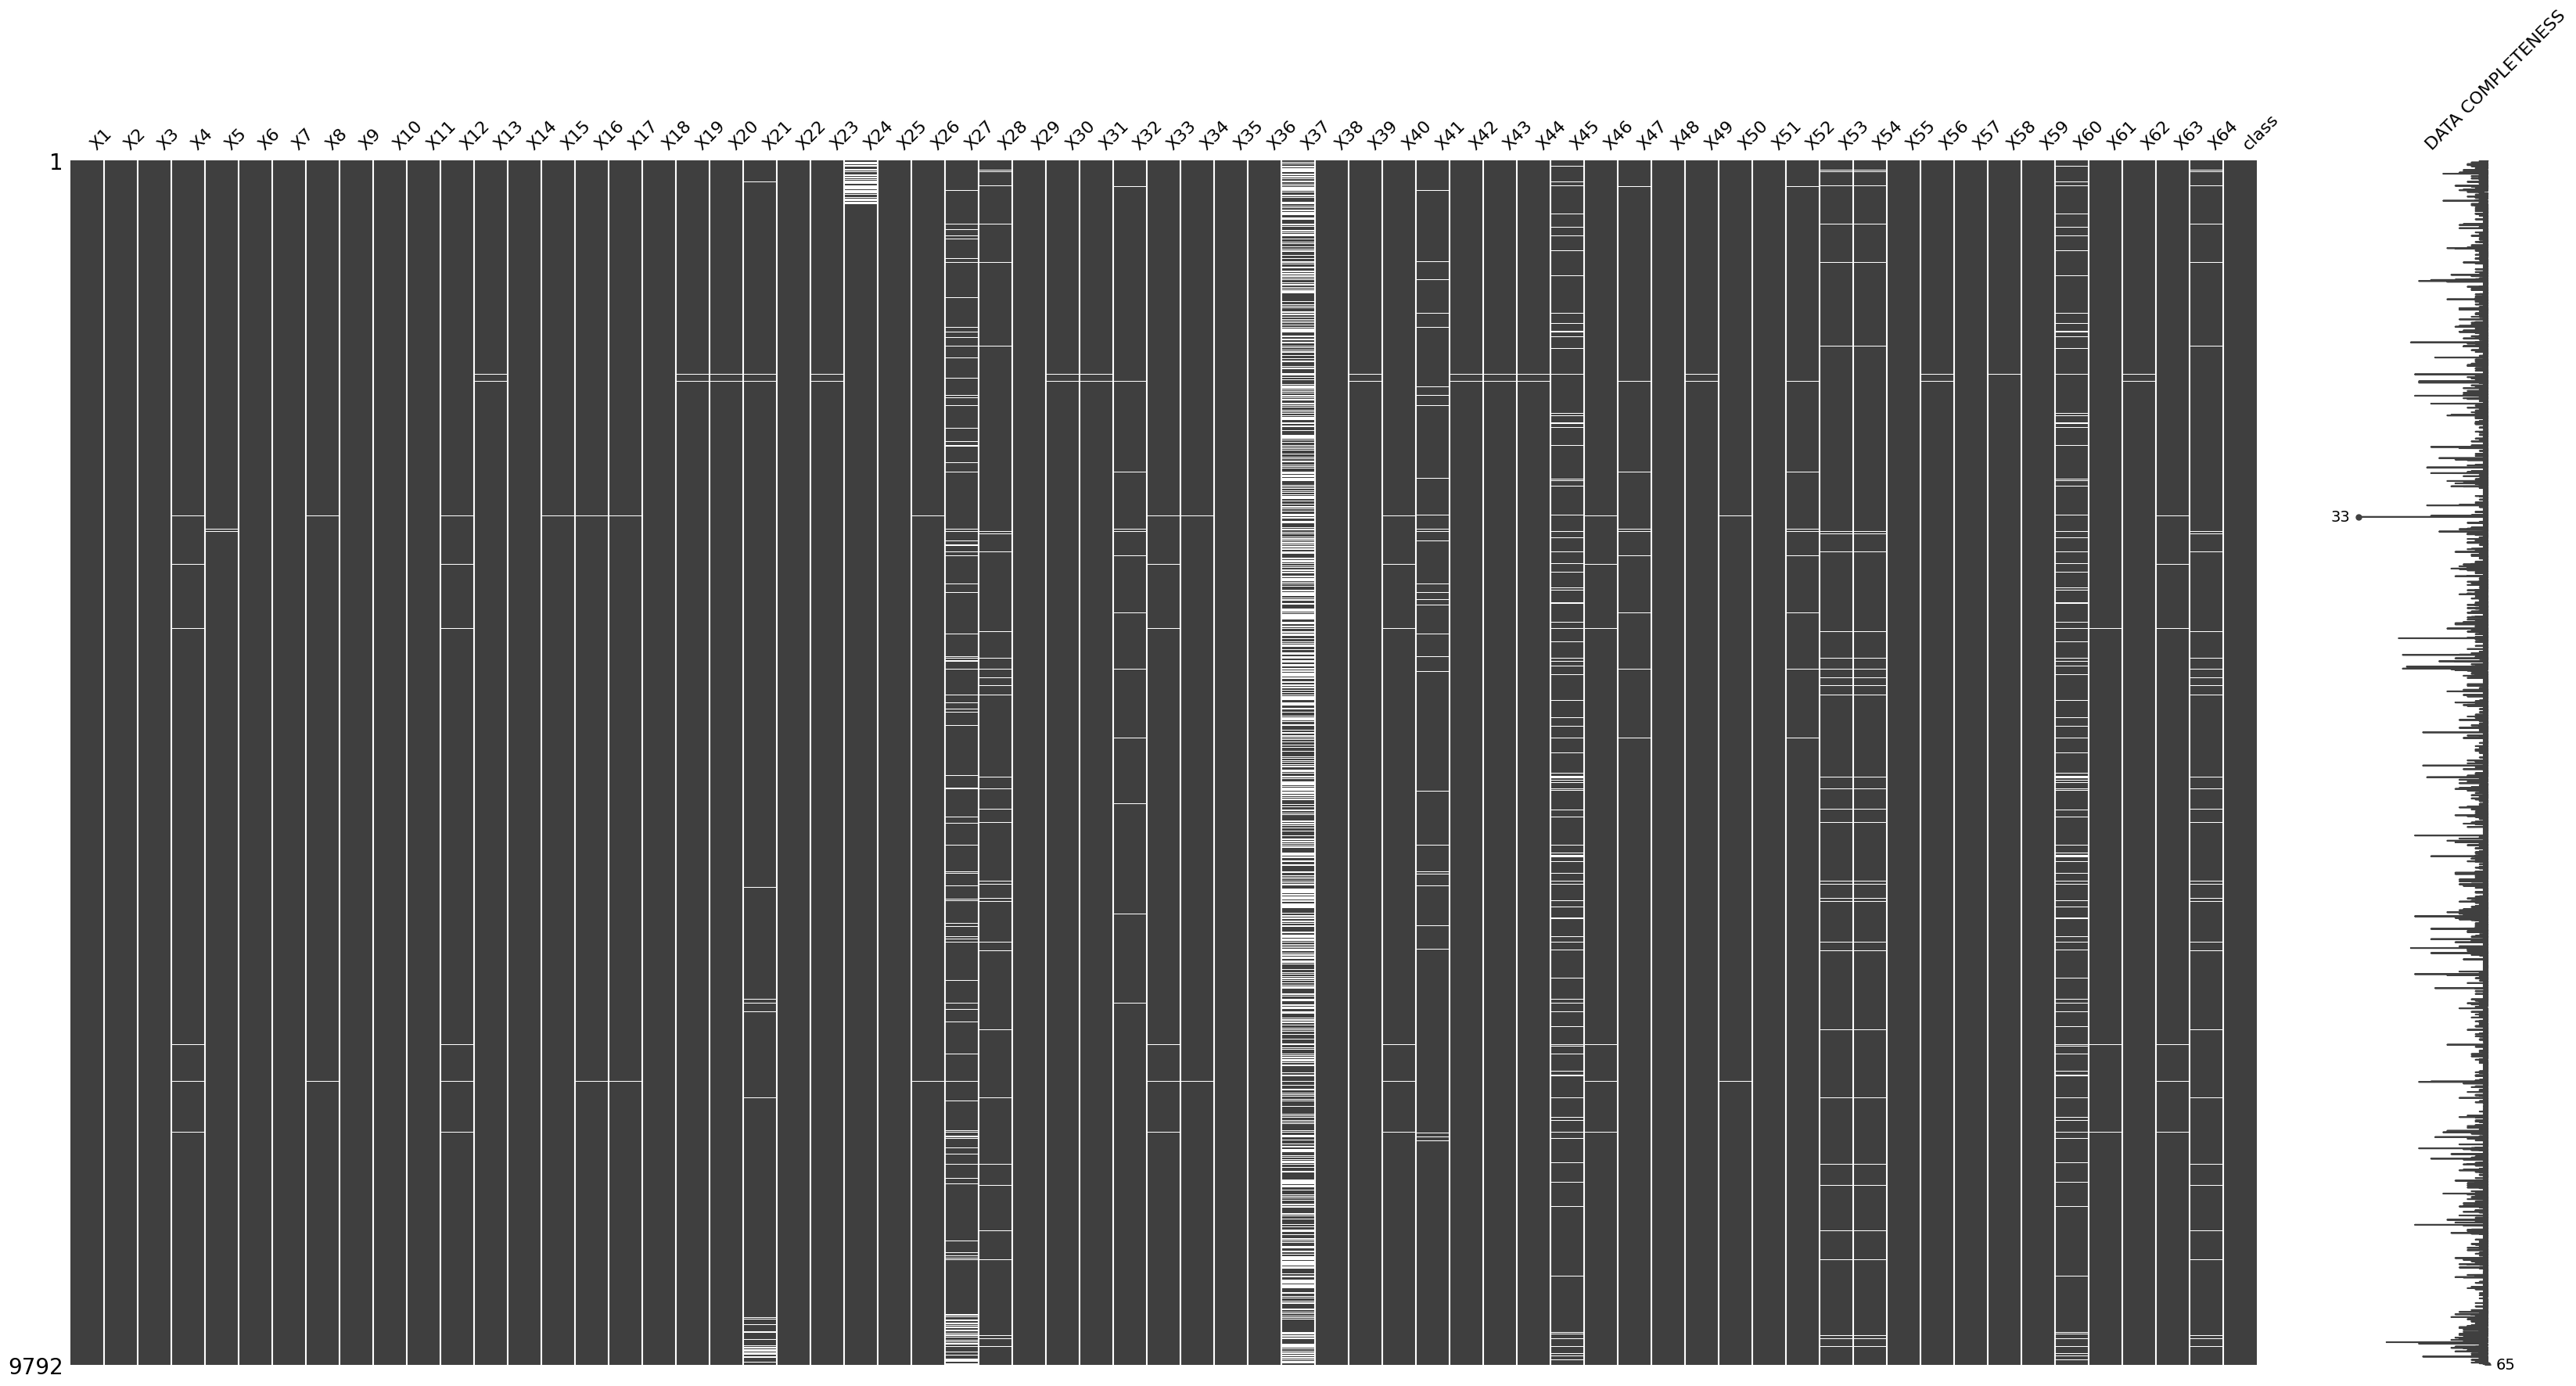

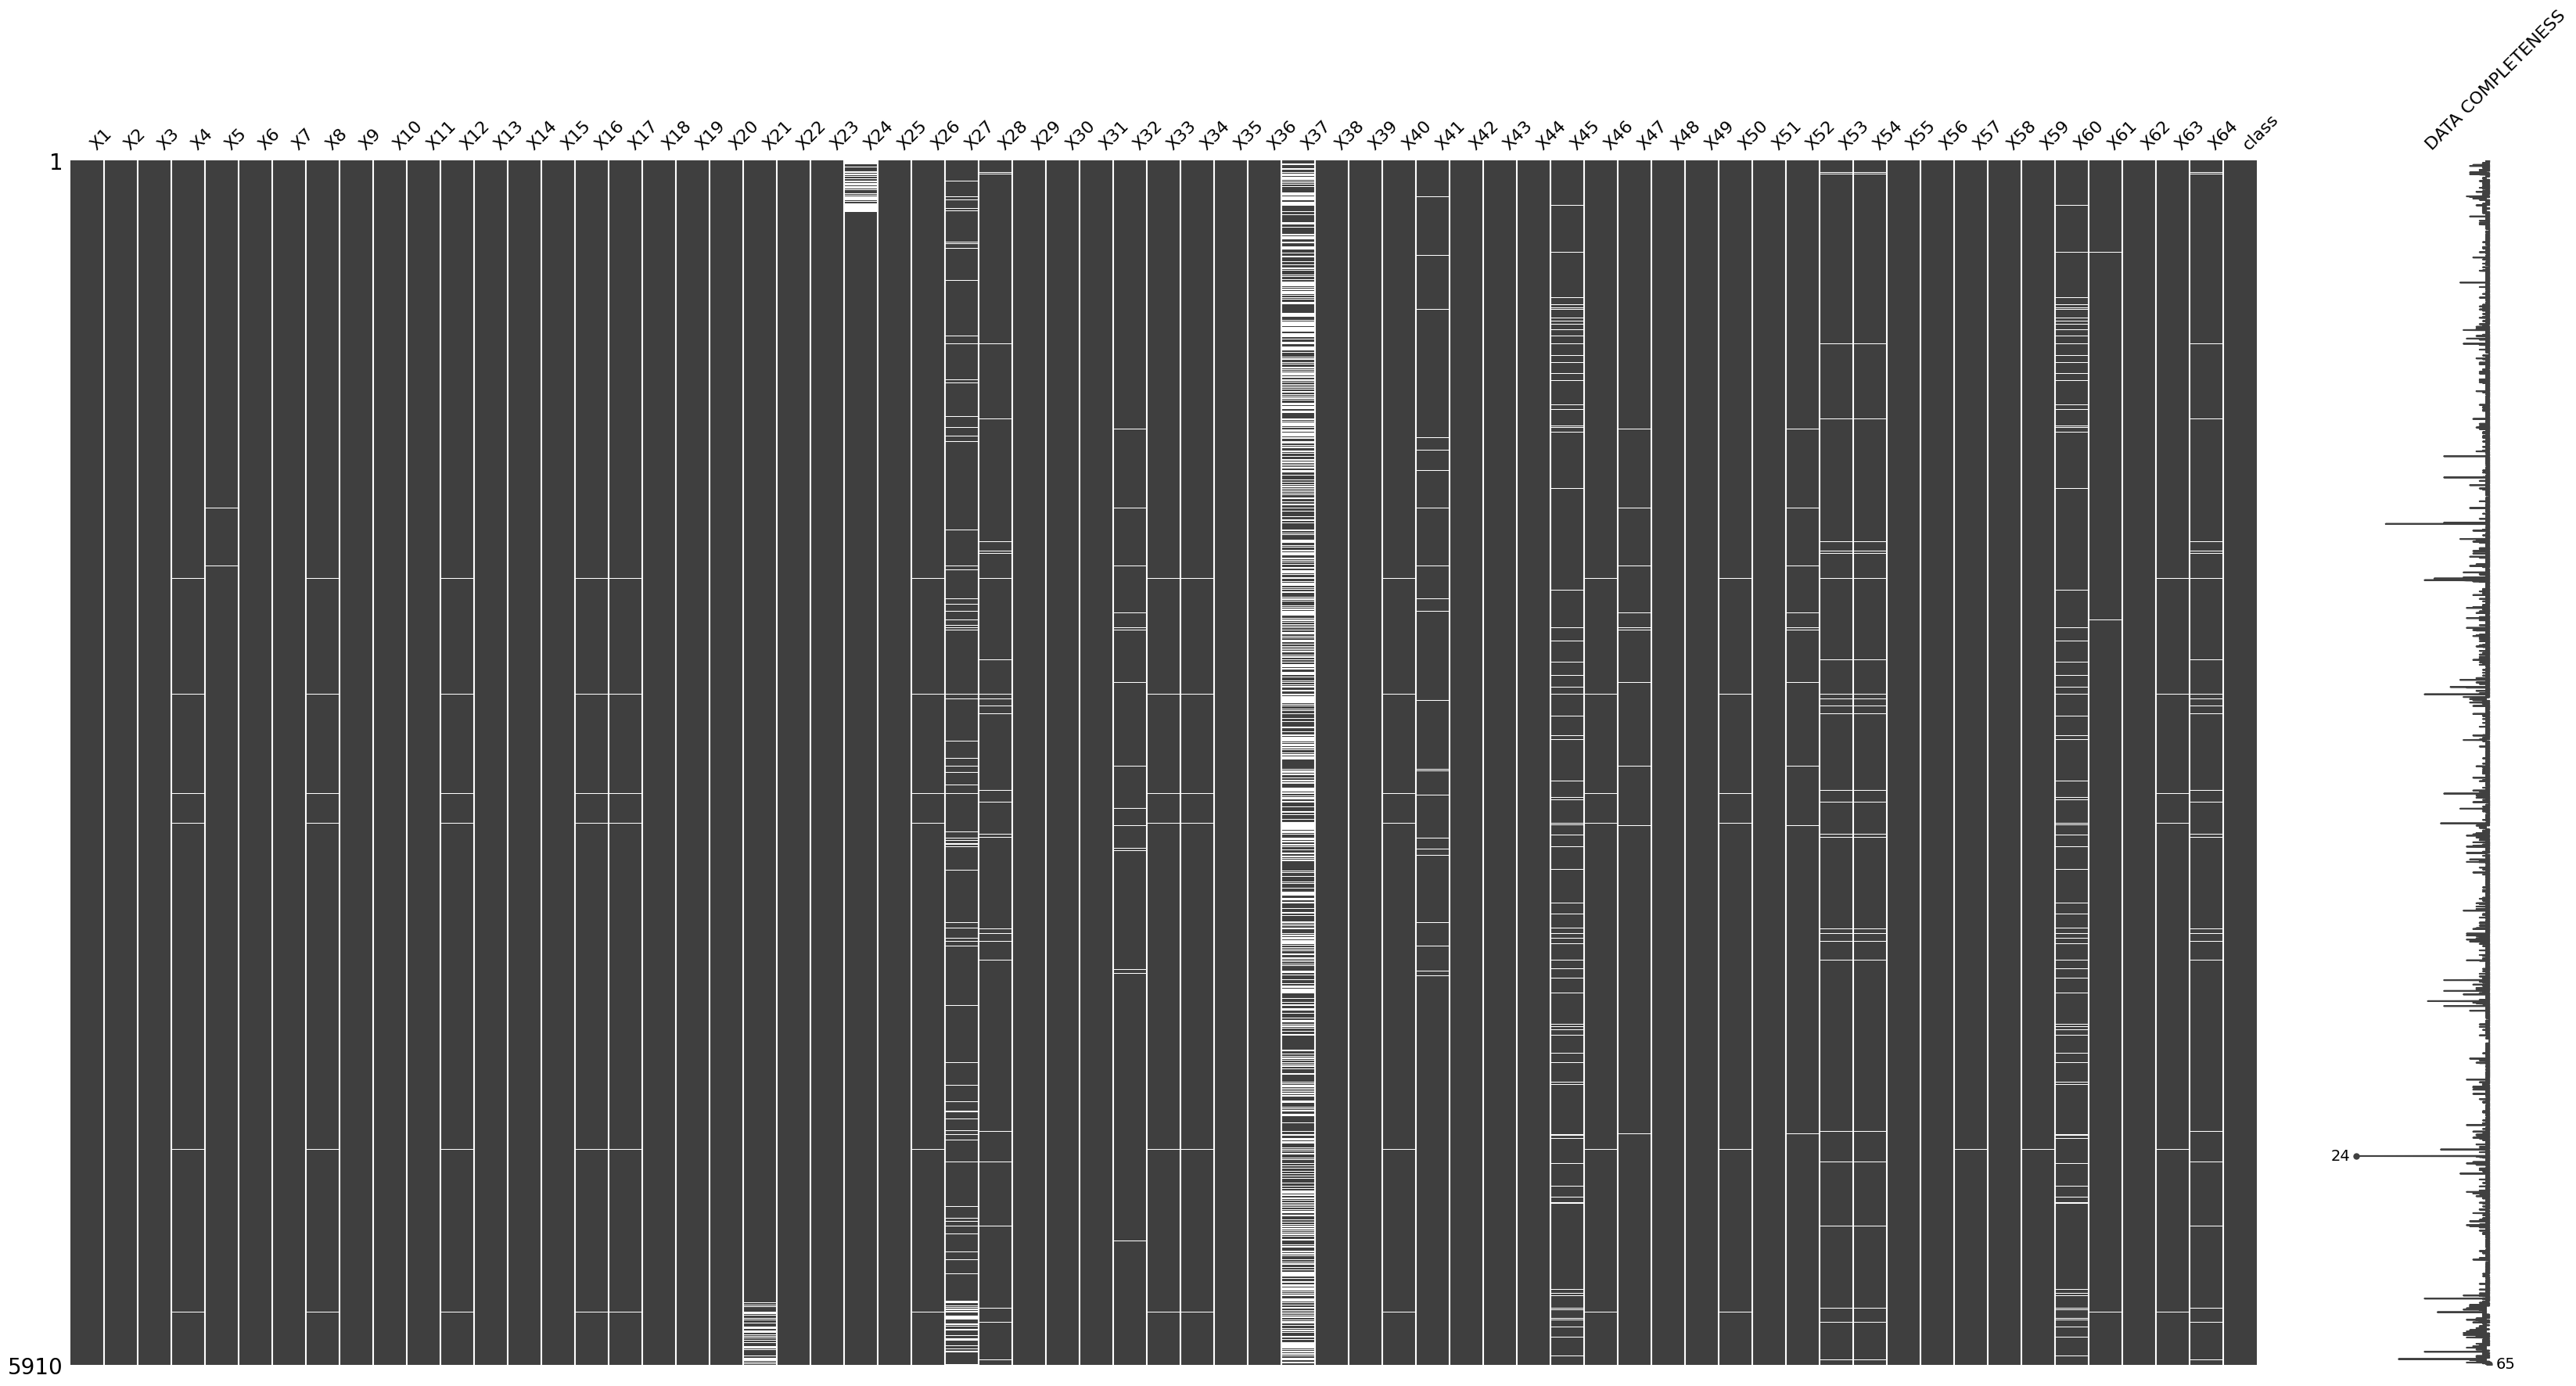

In [19]:
for data_set in data_sets:
    msno.matrix(data_set, labels=True, figsize=(40, 20))

Mozemo da primetimo da je najveci broj nedostajucih vrednosti za atribute X37 i X21. Daljom analizom cemo proveriti sta dalje raditi sa tim podacima. 

[[0.3899245766329871, 0.23082396470755656], [0.4441167797109997, 0.31101936498574656], [0.45091878510901645, 0.0768351899457298], [0.4536356209150327, 0.01613562091503268], [0.4311336717428088, 0.01742808798646362]]


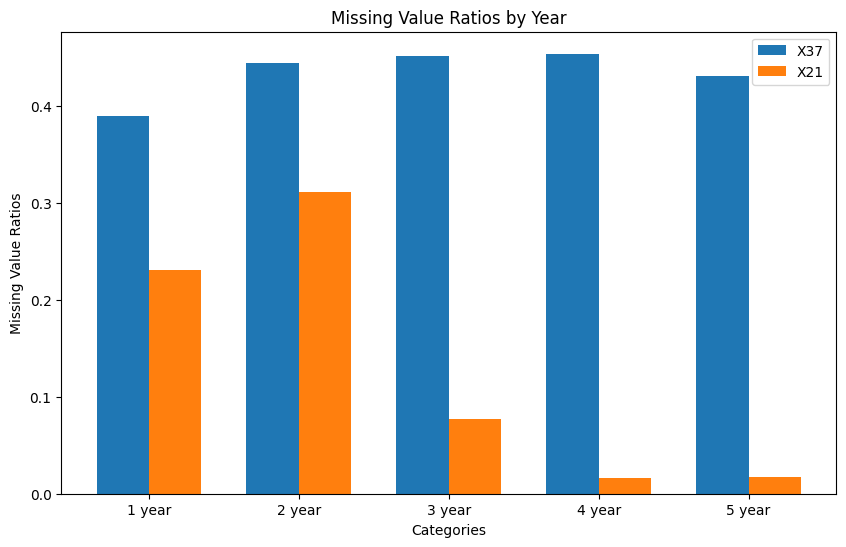

In [4]:
missing_ratio = []

for i, data_set in enumerate(data_sets):
    missing_ratio.append([data_set['X37'].isna().sum() / len(data_set), data_set['X21'].isna().sum() / len(data_set)])

print(missing_ratio)
categories = [f'{i} year' for i in range(1, len(data_sets)+1)]
                                         
ind = np.arange(len(data_sets))
bar_width = 0.35
                                         
plt.figure(figsize=(10, 6))
plt.bar(ind, [item[0] for item in missing_ratio], bar_width, label='X37')
plt.bar(ind + bar_width, [item[1] for item in missing_ratio], bar_width, label='X21')

plt.xlabel('Categories')
plt.ylabel('Missing Value Ratios')
plt.title('Missing Value Ratios by Year')
plt.xticks(ind + bar_width / 2, categories)
plt.legend()

plt.show()

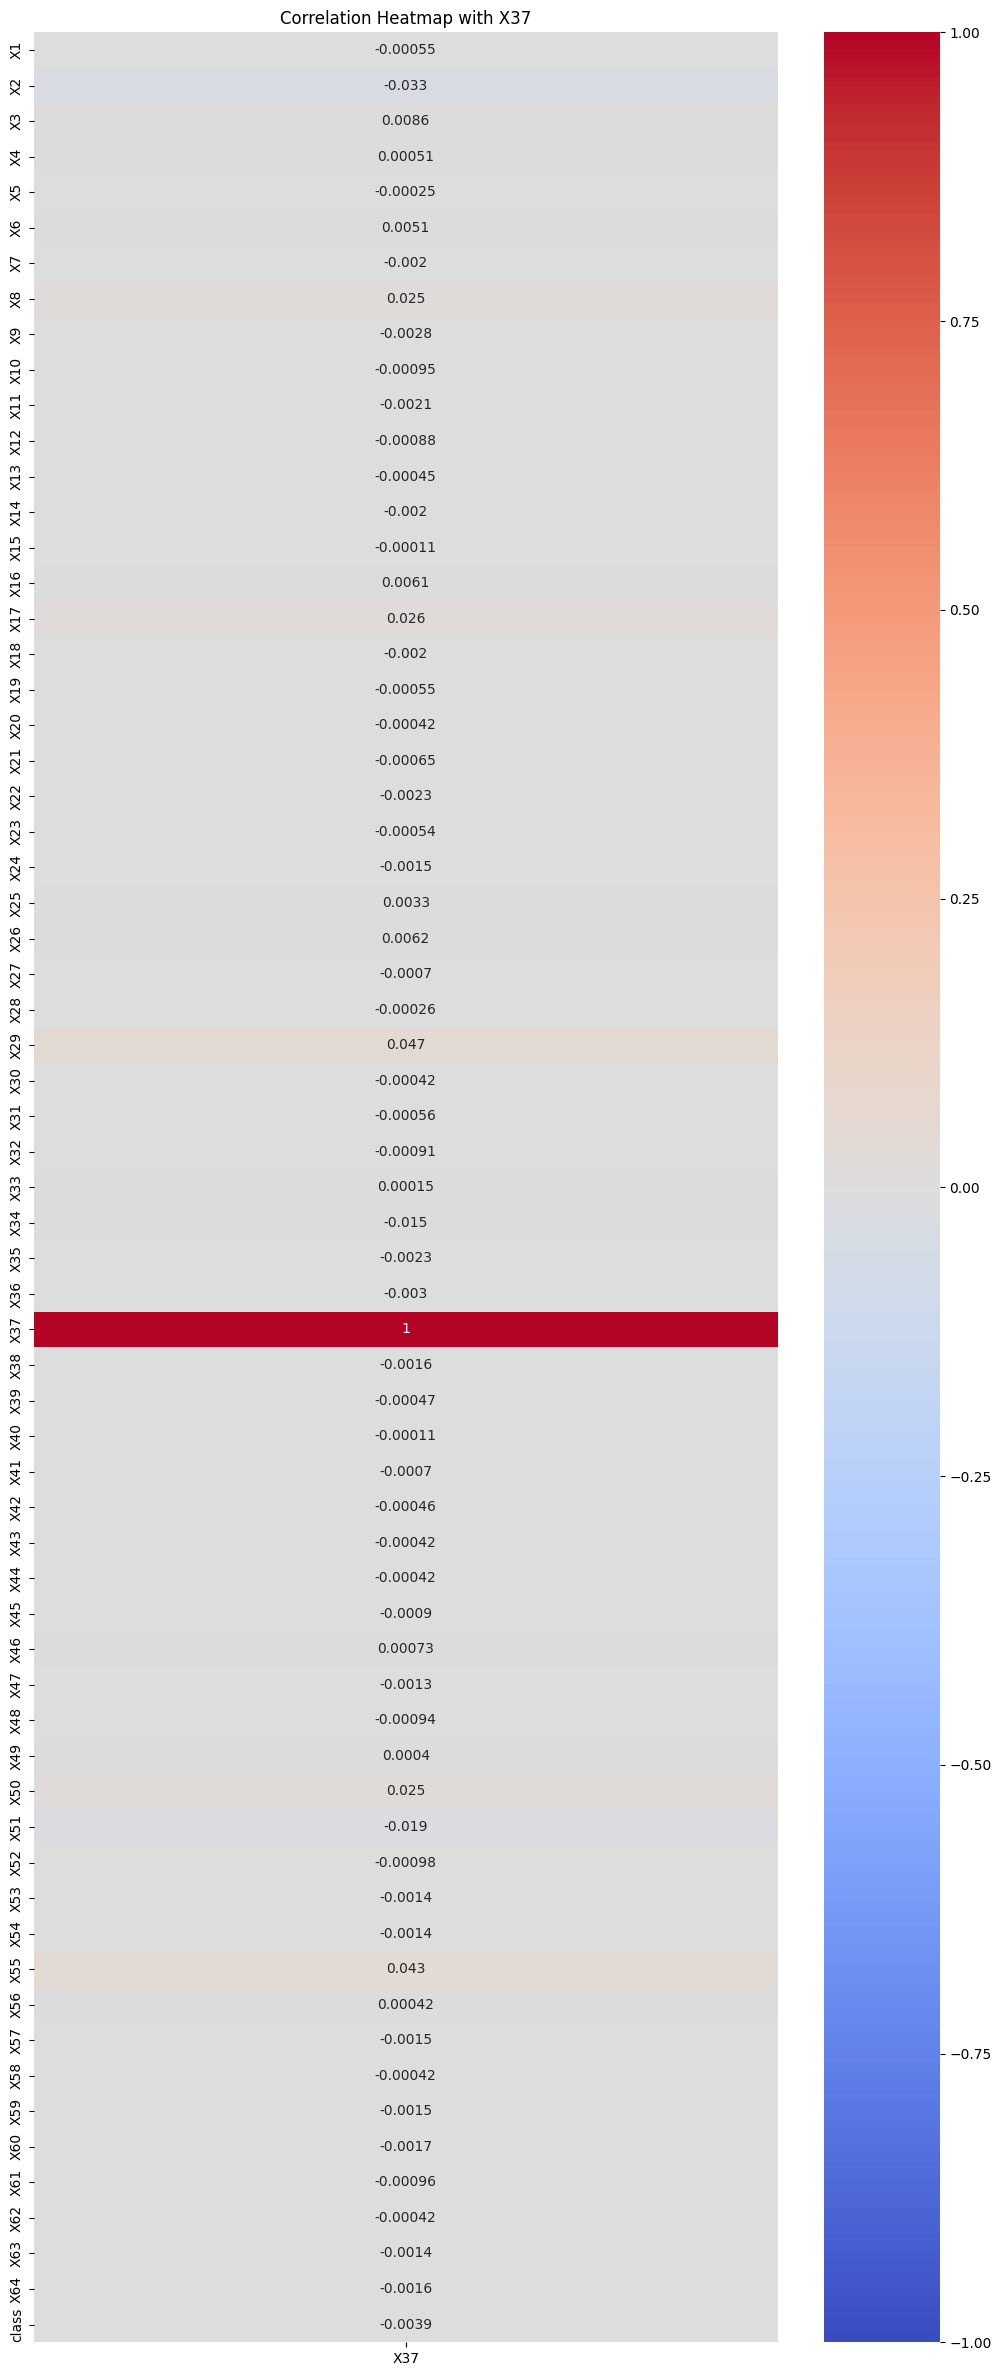

In [5]:
correlation_matrix = data_sets[0].corr()

# Prikazivanje Heatmap-a za korelaciju sa 'X37'
plt.figure(figsize=(12, 30))
sns.heatmap(correlation_matrix[['X37']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap with X37')
plt.show()

In [6]:
data_sets[0]['X37'].describe()

count      4287.000000
mean        173.453694
std        6339.491580
min        -525.520000
25%           1.296500
50%           3.438300
75%          11.393500
max      398920.000000
Name: X37, dtype: float64

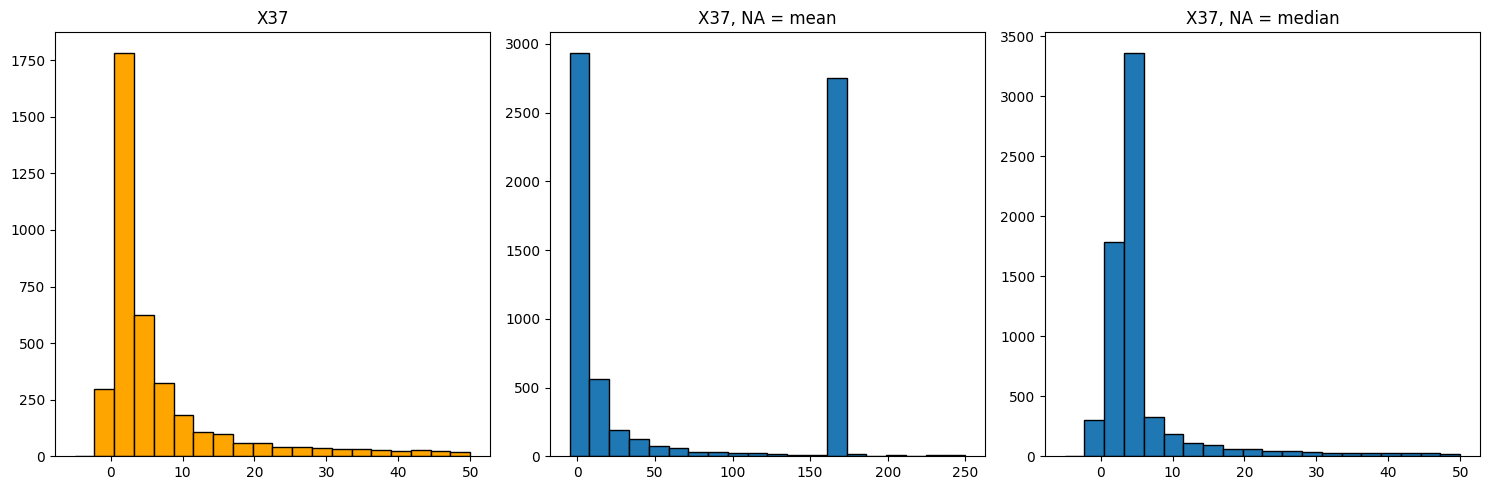

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Prvi subplot
axes[0].hist(data_sets[0]['X37'], edgecolor='black', range=(-5,50), bins=20, color='orange')
axes[0].set_title('X37')

# Drugi subplot
axes[1].hist(data_sets[0]['X37'].fillna(data_sets[0]['X37'].mean(), inplace=False), edgecolor='black', range=(-5,250), bins=20)
axes[1].set_title('X37, NA = mean')

# Treći subplot
axes[2].hist(data_sets[0]['X37'].fillna(data_sets[0]['X37'].median(), inplace=False), edgecolor='black', range=(-5,50), bins=20)
axes[2].set_title('X37, NA = median')

plt.tight_layout()
plt.show()

Iako ne postoji linearna znacajna korelisanost X37 i ostalih atributa (nizoj korelisanosti moze uticati i veliki broj nedostajucih vrednosti). Neke jednostavnije tehnike popunjavanja nedostajucih vrednosti bi nam dale iskrivljenu sliku i potencijalno nanele vise stete nego koristi.
Uzimajuci u obzir procenat podataka kojima nedostaje data vrednost i dimenzionalnost podataka dalju analizu nastavljamo bez datog atributa.

In [8]:
for data_set in data_sets:
    data_set.drop(columns=['X37'], inplace=True)

(array([   0.,    0.,    0.,    0.,    0.,    3.,   28.,  188., 2639.,
        1962.,  377.,   95.,   40.,   15.,    7.,    5.,    5.,    3.,
           3.,    0.]),
 array([-2.  , -1.65, -1.3 , -0.95, -0.6 , -0.25,  0.1 ,  0.45,  0.8 ,
         1.15,  1.5 ,  1.85,  2.2 ,  2.55,  2.9 ,  3.25,  3.6 ,  3.95,
         4.3 ,  4.65,  5.  ]),
 <BarContainer object of 20 artists>)

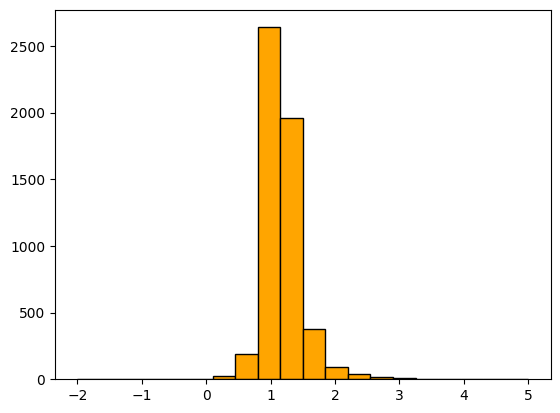

In [9]:
plt.hist(data_sets[0]['X21'], edgecolor='black', range=(-2,5), bins=20, color='orange', label='Raspodela X21 pre iterativnog algoritma')

In [10]:
data_sets[0][['X1', 'X21', 'X24', 'X27']].describe()

,X1,X21,X24,X27
count,7024.000000,5405.000000,6903.000000,6.716000e+03
mean,0.034660,10.367516,0.540231,1.321989e+03
std,4.565504,417.358298,13.501067,3.550416e+04
min,-256.890000,-1325.000000,-189.560000,-1.479000e+04
25%,0.021182,1.024400,0.049077,2.353975e-01
50%,0.075802,1.137400,0.164470,1.286450e+00
75%,0.160268,1.287600,0.336050,6.311925e+00
max,94.280000,27900.000000,831.660000,2.040800e+06


Iterativni algoritam moze se primeniti i na vecem broju atributa i u vecem broju iteracija. Posto sklearn biblioteka ne podrzava rad grafike kartice, ova procedura zahtevala bi previse vremena. Uzecemo kolone sa najvecim udelom nedostajucih vrednosti.

In [11]:
def iterative_imputation_alghorithm(d, columns):
    imptr = IterativeImputer(RandomForestRegressor(), max_iter=2, tol=0.01, random_state=0)
    d1 = pd.DataFrame(imptr.fit_transform(d[columns]), columns=columns)
    d1.info()
    return d1

columns_to_impute = ['X1', 'X21', 'X24', 'X27', 'X45', 'X60']

for data_set in data_sets:
    imputed_data = iterative_imputation_alghorithm(data_set, columns_to_impute)
    data_set[columns_to_impute] = imputed_data

data_sets[0][columns_to_impute].info()

/home/korisnik/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7027 entries, 0 to 7026
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      7027 non-null   float64
 1   X21     7027 non-null   float64
 2   X24     7027 non-null   float64
 3   X27     7027 non-null   float64
 4   X45     7027 non-null   float64
 5   X60     7027 non-null   float64
dtypes: float64(6)
memory usage: 329.5 KB


/home/korisnik/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10173 entries, 0 to 10172
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      10173 non-null  float64
 1   X21     10173 non-null  float64
 2   X24     10173 non-null  float64
 3   X27     10173 non-null  float64
 4   X45     10173 non-null  float64
 5   X60     10173 non-null  float64
dtypes: float64(6)
memory usage: 477.0 KB


/home/korisnik/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10503 entries, 0 to 10502
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      10503 non-null  float64
 1   X21     10503 non-null  float64
 2   X24     10503 non-null  float64
 3   X27     10503 non-null  float64
 4   X45     10503 non-null  float64
 5   X60     10503 non-null  float64
dtypes: float64(6)
memory usage: 492.5 KB


/home/korisnik/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9792 entries, 0 to 9791
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      9792 non-null   float64
 1   X21     9792 non-null   float64
 2   X24     9792 non-null   float64
 3   X27     9792 non-null   float64
 4   X45     9792 non-null   float64
 5   X60     9792 non-null   float64
dtypes: float64(6)
memory usage: 459.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      5910 non-null   float64
 1   X21     5910 non-null   float64
 2   X24     5910 non-null   float64
 3   X27     5910 non-null   float64
 4   X45     5910 non-null   float64
 5   X60     5910 non-null   float64
dtypes: float64(6)
memory usage: 277.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7027 entries, 0 to 7026
Data columns (total 6 columns):
 #   C

/home/korisnik/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        3.000e+01, 1.900e+02, 2.866e+03, 2.879e+03, 6.560e+02, 1.770e+02,
        6.600e+01, 2.200e+01, 1.400e+01, 1.200e+01, 9.000e+00, 9.000e+00,
        5.000e+00, 2.000e+00]),
 array([-2.  , -1.65, -1.3 , -0.95, -0.6 , -0.25,  0.1 ,  0.45,  0.8 ,
         1.15,  1.5 ,  1.85,  2.2 ,  2.55,  2.9 ,  3.25,  3.6 ,  3.95,
         4.3 ,  4.65,  5.  ]),
 <BarContainer object of 20 artists>)

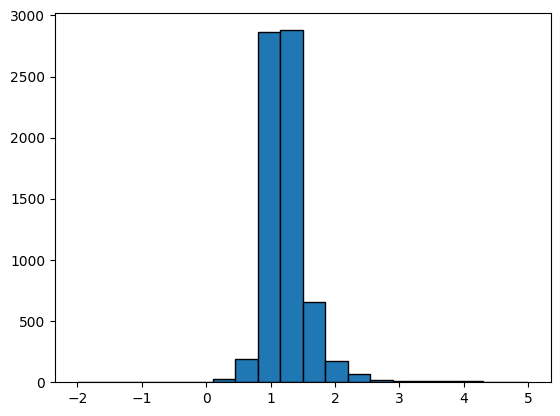

In [12]:
# vidimo da je raspodela otprilike zadrzala svoj oblik
plt.hist(data_sets[0]['X21'], edgecolor='black', range=(-2,5), bins=20, label='Raspodela nakon primene iterativnog algoritma')

In [13]:
missing_data = []

for data_set in data_sets:
    len1 = len(data_set)
    len2 = len(data_set.dropna(inplace=False))
    ratio = 1-len2 / len1
    missing_data.append([len1, len2, ratio])
    
missing_data = pd.DataFrame(np.array(missing_data), columns=['total', 'missing value', 'data loss'],
                        index=[f'{i} year' for i in range(1, 6)])
missing_data

,total,missing value,data loss
1 year,7027.0,6809.0,0.031023
2 year,10173.0,9655.0,0.050919
3 year,10503.0,9957.0,0.051985
4 year,9792.0,9250.0,0.055351
5 year,5910.0,5669.0,0.040778


Ostale nedostajuce vrednosti, kojih ima oko 5%, nadokndicemo primenom KNN Imputation metode.

In [14]:
import fancyimpute

def perform_knn_imputation(dfs):
    knn_imputed_datasets = [fancyimpute.KNN(k=50, verbose=True).fit_transform(dfs[i]) for i in range(len(dfs))]
    return [pd.DataFrame(data=knn_imputed_datasets[i]) for i in range(len(dfs))]

knn_imputed_dataframes = perform_knn_imputation(data_sets)

Imputing row 1/7027 with 0 missing, elapsed time: 15.099
Imputing row 101/7027 with 0 missing, elapsed time: 15.100
Imputing row 201/7027 with 0 missing, elapsed time: 15.100
Imputing row 301/7027 with 0 missing, elapsed time: 15.101
Imputing row 401/7027 with 0 missing, elapsed time: 15.102
Imputing row 501/7027 with 0 missing, elapsed time: 15.102
Imputing row 601/7027 with 0 missing, elapsed time: 15.102
Imputing row 701/7027 with 0 missing, elapsed time: 15.103
Imputing row 801/7027 with 0 missing, elapsed time: 15.103
Imputing row 901/7027 with 0 missing, elapsed time: 15.103
Imputing row 1001/7027 with 0 missing, elapsed time: 15.103
Imputing row 1101/7027 with 0 missing, elapsed time: 15.103
Imputing row 1201/7027 with 0 missing, elapsed time: 15.104
Imputing row 1301/7027 with 0 missing, elapsed time: 15.104
Imputing row 1401/7027 with 0 missing, elapsed time: 15.105
Imputing row 1501/7027 with 0 missing, elapsed time: 15.105
Imputing row 1601/7027 with 0 missing, elapsed time:

Imputing row 1/10503 with 0 missing, elapsed time: 42.473
Imputing row 101/10503 with 0 missing, elapsed time: 42.475
Imputing row 201/10503 with 0 missing, elapsed time: 42.475
Imputing row 301/10503 with 0 missing, elapsed time: 42.476
Imputing row 401/10503 with 0 missing, elapsed time: 42.477
Imputing row 501/10503 with 0 missing, elapsed time: 42.477
Imputing row 601/10503 with 0 missing, elapsed time: 42.478
Imputing row 701/10503 with 0 missing, elapsed time: 42.479
Imputing row 801/10503 with 0 missing, elapsed time: 42.479
Imputing row 901/10503 with 0 missing, elapsed time: 42.480
Imputing row 1001/10503 with 0 missing, elapsed time: 42.480
Imputing row 1101/10503 with 0 missing, elapsed time: 42.481
Imputing row 1201/10503 with 0 missing, elapsed time: 42.482
Imputing row 1301/10503 with 0 missing, elapsed time: 42.482
Imputing row 1401/10503 with 0 missing, elapsed time: 42.483
Imputing row 1501/10503 with 0 missing, elapsed time: 42.484
Imputing row 1601/10503 with 0 missi

Imputing row 1/5910 with 0 missing, elapsed time: 8.792
Imputing row 101/5910 with 0 missing, elapsed time: 8.793
Imputing row 201/5910 with 0 missing, elapsed time: 8.794
Imputing row 301/5910 with 0 missing, elapsed time: 8.794
Imputing row 401/5910 with 0 missing, elapsed time: 8.794
Imputing row 501/5910 with 0 missing, elapsed time: 8.794
Imputing row 601/5910 with 0 missing, elapsed time: 8.795
Imputing row 701/5910 with 0 missing, elapsed time: 8.795
Imputing row 801/5910 with 0 missing, elapsed time: 8.795
Imputing row 901/5910 with 0 missing, elapsed time: 8.795
Imputing row 1001/5910 with 0 missing, elapsed time: 8.796
Imputing row 1101/5910 with 0 missing, elapsed time: 8.796
Imputing row 1201/5910 with 0 missing, elapsed time: 8.796
Imputing row 1301/5910 with 0 missing, elapsed time: 8.796
Imputing row 1401/5910 with 0 missing, elapsed time: 8.797
Imputing row 1501/5910 with 0 missing, elapsed time: 8.797
Imputing row 1601/5910 with 0 missing, elapsed time: 8.798
Imputing 

In [15]:
for data_frame in knn_imputed_dataframes:
    data_frame.columns = data_sets[0].columns

In [16]:
data = pd.concat(knn_imputed_dataframes, ignore_index=True)
data.columns = knn_imputed_dataframes[0].columns

## Rad sa outlier-ima

In [17]:
X = data.drop('class', axis=1)
Y = data['class']

def IQR(data, feature_names):
    
    iqr = pd.DataFrame(0, index=feature_names, columns=['lower', 'min', 'num_lower', 'upper', 'max', 'num_upper', 'percantage'])
    for name in feature_names:

        (Q1, Q3) = X[name].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        upper = Q3 + (1.5 * IQR)
        lower = Q1 - (1.5 * IQR)
        
        iqr.loc[name, 'upper'] = upper
        iqr.loc[name, 'lower'] = lower

        num_of_out_lower = (X[name] < lower).sum()
        num_of_out_upper = (X[name] > upper).sum()

        percentage = round((num_of_out_lower + num_of_out_upper) / X.shape[0] * 100)

        iqr.loc[name, 'num_lower'], iqr.loc[name, 'num_upper'], iqr.loc[name, 'percantage']  = num_of_out_lower, num_of_out_upper, percentage
        iqr.loc[name, 'min'], iqr.loc[name, 'max'] = min(X[name]), max(X[name])    
    return iqr

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=41)
IQR(X_train, X.columns)

,lower,min,num_lower,upper,max,num_upper,percantage
X1,-0.185833,-4.638900e+02,2247,0.318844,9.428000e+01,2425,11
X2,-0.360105,-4.308700e+02,3,1.317295,4.809600e+02,1070,2
X3,-0.551280,-4.799600e+02,1053,0.976240,2.833600e+01,133,3
X4,-1.577200,-4.031100e-01,0,5.430800,5.343300e+04,4559,11
X5,-198.876000,-1.190300e+07,2988,200.572000,1.250100e+06,3232,14
...,...,...,...,...,...,...,...
X60,-21.457750,-1.244000e+01,0,51.039450,4.818700e+06,6166,14
X61,-4.347750,-1.265600e+01,2,19.287050,1.080000e+05,3944,9
X62,-70.612500,-2.336500e+06,6,230.095500,2.501600e+07,3123,7
X63,-5.196050,-1.543200e+00,0,16.926750,2.345400e+04,3438,8


Trebalo bi se pozabaviti da outlier pre nastavka dalje analize, posto cine veliki udeo podataka.

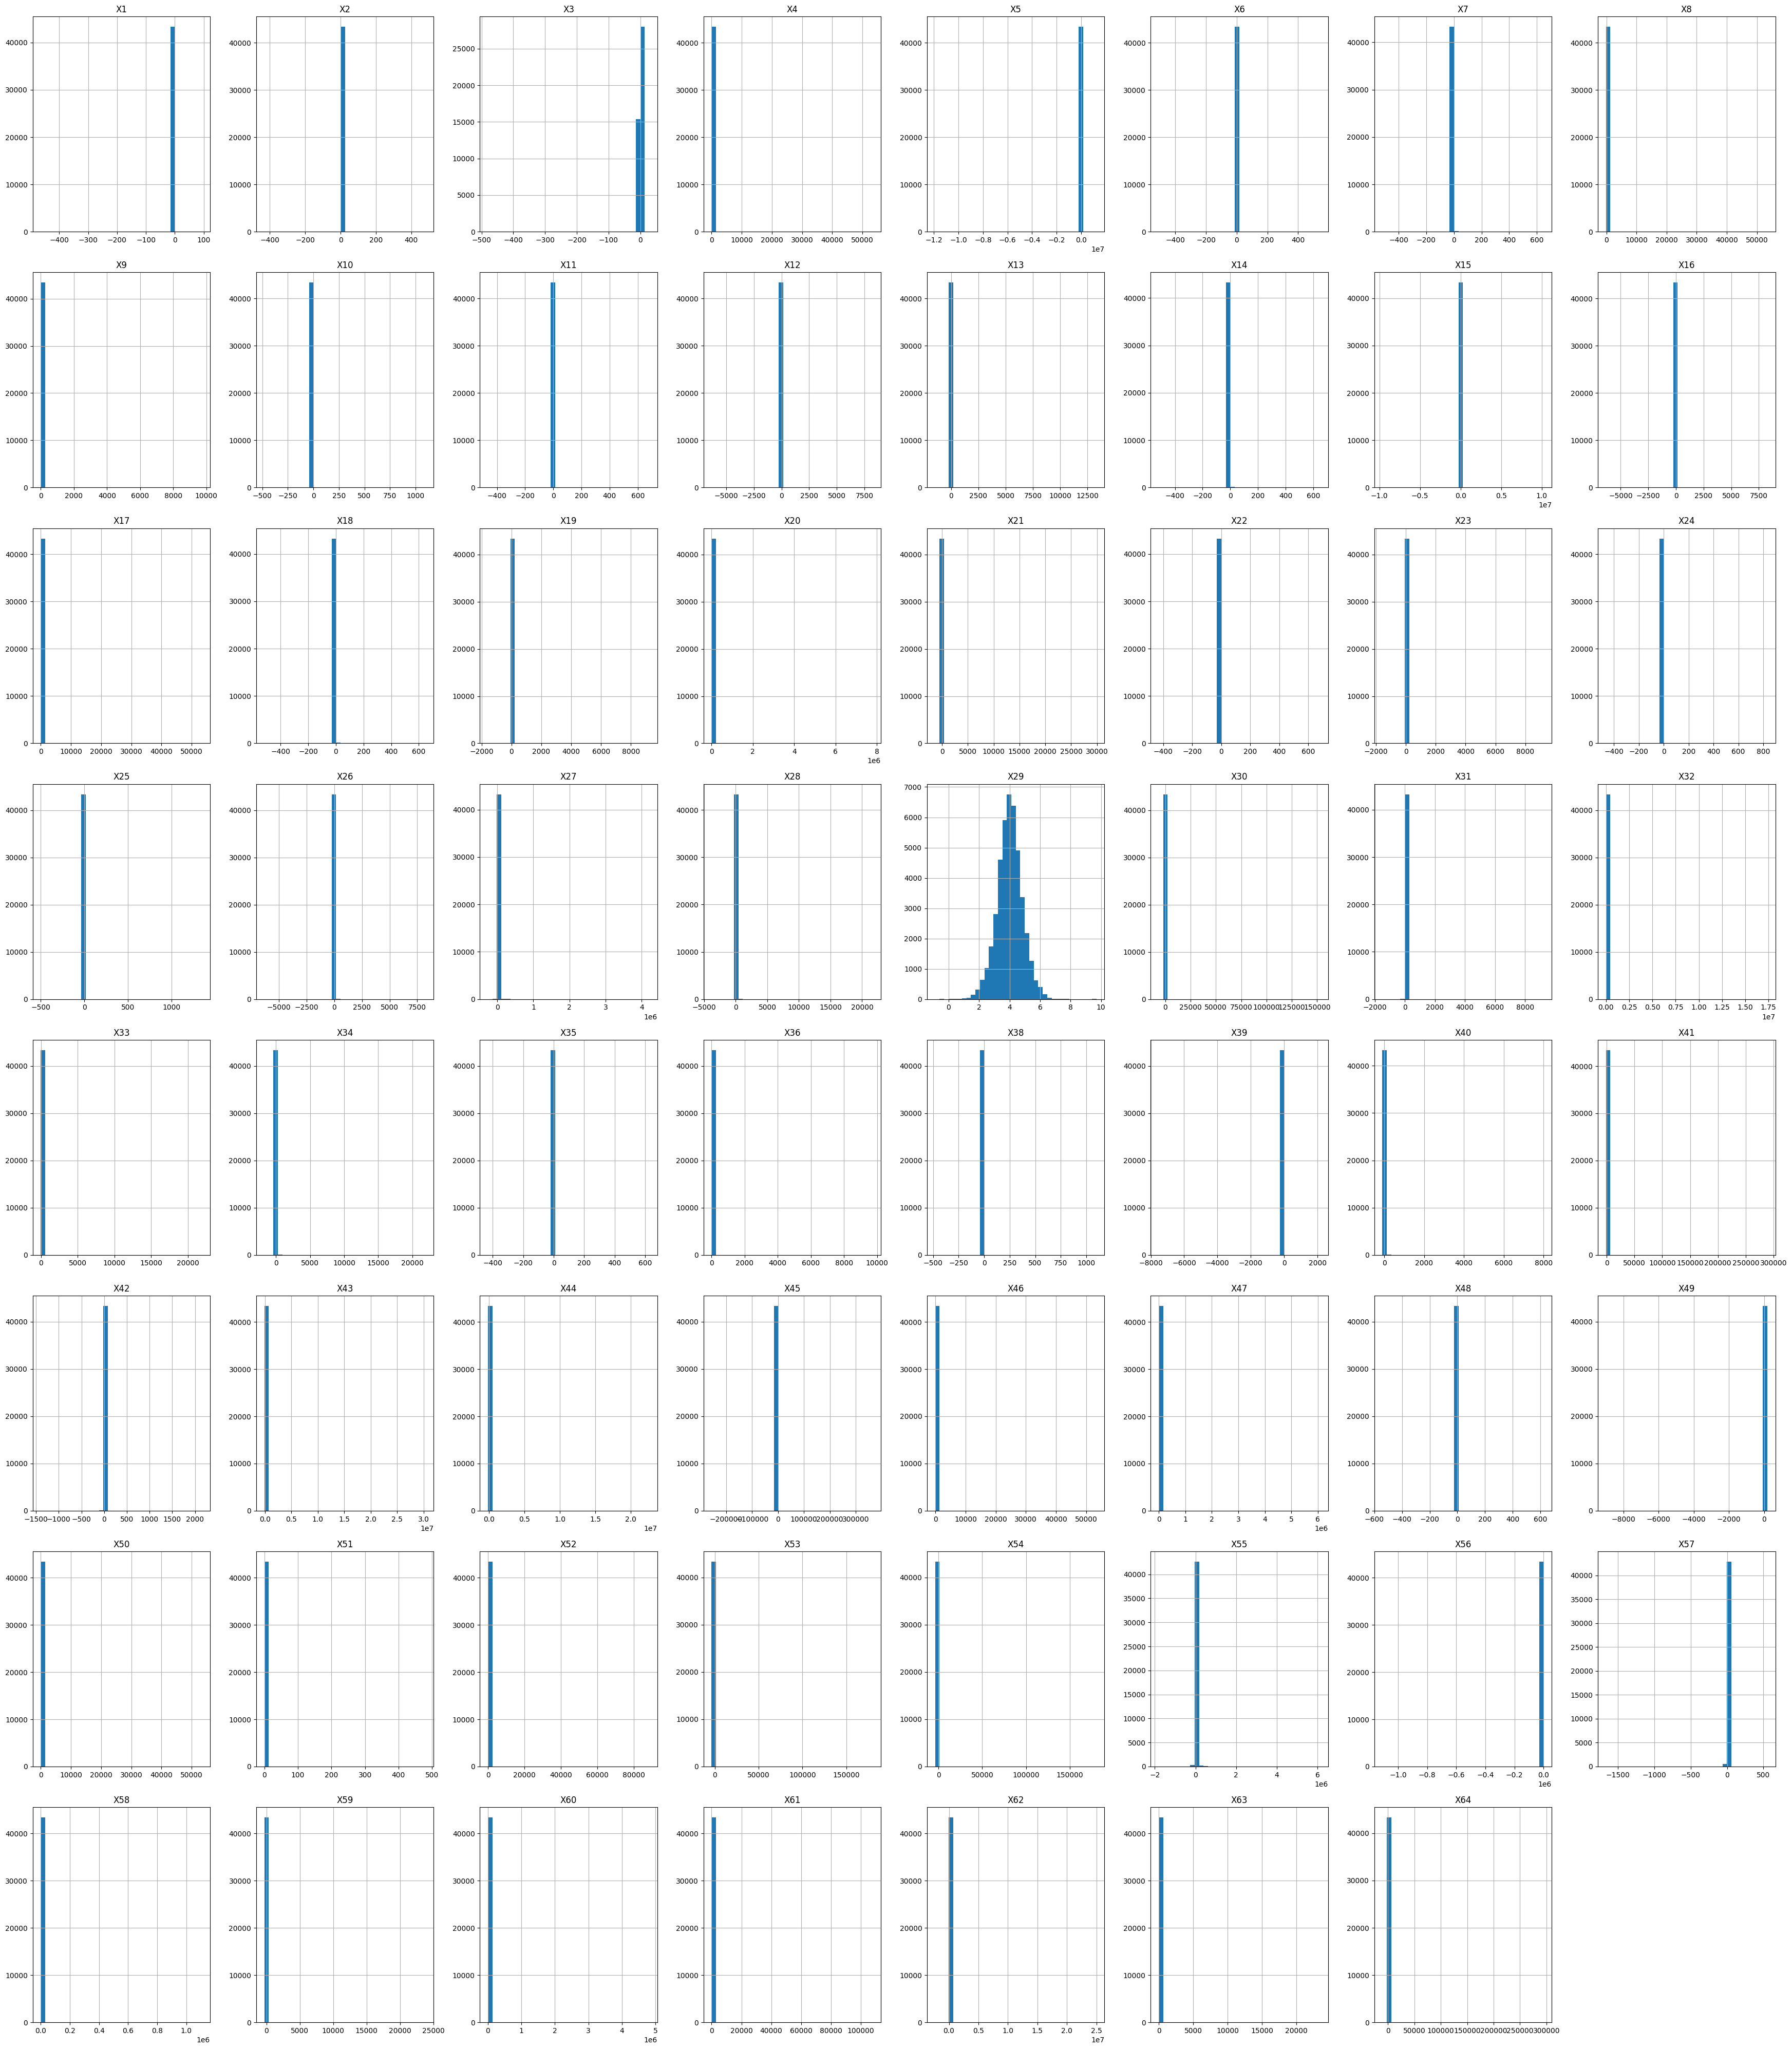

In [19]:
X.hist(bins=36, figsize=(35, 40))
plt.tight_layout()
plt.show()

Mozemo primetiti da vecina atributa, osim atributa X29 sadrzi znacajan broj outliere koji su siroko rasprseni i dosta odskacu od standardnih vrednosti. Pre primene modela, trebalo bi doneti odluku sta raditi sa outlierima, uzimajuci u obzir da nam upravo oni mogu dati znacajne informacije o potencijalnom bankrotstvu kompanije.

In [20]:
from joblib import dump

dump((X_train, X_test, Y_train, Y_test), 'classification_data.joblib')

['classification_data.joblib']

In [21]:
X_train

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
22192,0.041204,0.64124,0.146990,1.65190,-15.4870,-0.004128,0.061988,0.559480,1.40550,0.358760,...,833.590,0.047137,0.114850,0.95634,1.100300,6.9667,9.2662,58.554,6.2336,2.23970
20226,-0.021822,0.97651,-0.186630,0.36003,-93.8940,-0.173830,-0.021822,0.024053,0.84317,0.023488,...,-2911.000,0.032609,-0.929090,1.02560,26.854000,98.5600,10.3410,126.240,2.8913,0.94208
39763,0.088265,0.27322,0.457700,2.89670,31.9070,0.000000,0.088265,2.660000,1.25660,0.726780,...,13076.000,0.274500,0.121450,0.72782,0.043906,3.3063,4.3147,70.094,5.2073,4.17490
37496,-0.006202,0.48465,0.232980,1.59980,6.1825,0.000000,-0.006202,1.063400,1.27570,0.515350,...,2341.800,-0.028591,-0.012035,1.00470,0.152220,6.0911,3.2749,111.140,3.2841,3.37000
16734,-0.044153,0.66832,-0.042477,0.92426,-320.9200,0.120160,-0.062196,0.487970,0.75368,0.326120,...,-7378.000,0.264660,-0.135390,1.09970,0.329670,2.3642,8.9120,271.590,1.3439,1.56470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13994,0.155870,0.60781,0.286020,1.47060,245.4500,0.000000,0.188070,0.645260,2.33460,0.392190,...,547.110,0.092712,0.397440,0.93981,0.000000,13.8440,4.5447,95.028,3.8410,21.98800
35706,0.017103,0.55330,0.346650,6.82290,48.1490,-0.227100,0.017103,0.807330,0.54779,0.446700,...,226.450,0.144070,0.038288,0.86843,1.105400,1.9293,6.1267,39.667,9.2017,0.92247
42841,0.084853,0.38888,0.097196,1.37100,-40.5560,0.095517,0.104860,1.571500,1.07980,0.611120,...,1.371,0.220850,0.138850,0.81587,0.207620,7.6045,6.2990,88.559,4.1215,1.68510
22548,0.021623,0.46550,0.215130,1.46210,25.3260,0.044193,0.029075,1.020200,1.02040,0.474890,...,16225.000,0.020034,0.045533,0.97997,0.000000,11.6280,2.6276,121.560,3.0026,4.37650
